In [14]:
confusion_matrix = []
with open('outfile_kuba.txt', 'r') as f:
    l = [[int(float(num)) for num in line.split(' ')] for line in f]
    confusion_matrix.append(l)



In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# a = np.random.random((16, 16))
plt.imshow(confusion_matrix[0], cmap='hot', interpolation='nearest')
plt.show()

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(confusion_matrix[0], linewidth=0.5)
plt.show()

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# df_cm = pd.DataFrame(tmp, range(6), range(6))
# plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(tmp, annot=True, annot_kws={"size": 16}) # font size

plt.show()

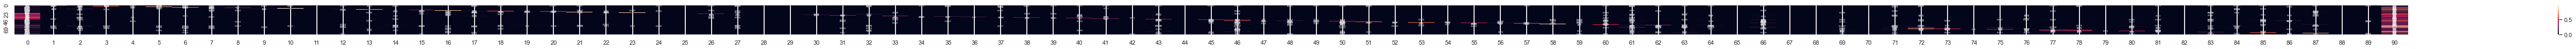

In [23]:
tmp = []
for row in confusion_matrix[0]:
    normalized_row = []
    for value in row:
        normalized_row.append(value/(sum(row)+1))
    tmp.append(normalized_row)


df_cm = pd.DataFrame(tmp, range(91), range(91))
plt.figure(figsize=(100,1))
sn.set(font_scale=1) # for label size
sn.heatmap(tmp, annot=True, annot_kws={"size": 4}) # font size
plt.show()



